In [12]:
""" Classes for each VQA"""

from pennylane import numpy as np
import pennylane as qml
import networkx as nx
from pennylane import qaoa


class QAOA_MaxCut:
    """
    VQA with StronglyEntangling layers as the ansatz and Z1+Z2+Z3+Z4 as the Hamiltonian
    Pennylane
    """

    def __init__(self, max_iterations=100, step_size=0.01, conv_tol=1e-05, noise_lvl=0):

        # OPTIMIZATION PARAMETERS
        self.max_iterations = max_iterations
        self.conv_tol = conv_tol
        self.noise_lvl = noise_lvl
        self.opt = qml.GradientDescentOptimizer(step_size)

        # CIRCUIT PARAMETERS
        nqubits = 4
        nlayers = 2

        # DEFINE GRAPH
        edges = [(0, 1), (1, 2), (2, 0), (2, 3)]
        graph = nx.Graph(edges)

        # DEVICE
        dev = qml.device('default.mixed', wires=nqubits)

        # HAMILTONIANS
        cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

        # ANSTAZ AND COST
        def qaoa_layer(gamma, alpha):
            qaoa.cost_layer(gamma, cost_h)
            qaoa.mixer_layer(alpha, mixer_h)

        @qml.qnode(dev)
        def cost(params):
            for i in range(nqubits):
                qml.Hadamard(wires=i)
            qml.layer(qaoa_layer, nlayers, params[0], params[1])
            return qml.expval(cost_h)
        self.cost = cost
        self.param_shape = (2, nlayers)

    def __call__(self, initial_params, ):
        params = initial_params
        cost_hist = []
        for _ in range(self.max_iterations):
            params, prev_energy = self.opt.step_and_cost(self.cost, params)
            params += np.random.normal(loc=0, scale=self.noise_lvl, size=params.shape)
            cost_hist.append(prev_energy)
            energy = self.cost(params)
            # conv = np.abs(energy - prev_energy)
            # if conv <= self.conv_tol: break
        return cost_hist, energy, params


In [13]:
A = QAOA_MaxCut()

In [19]:
initial_params = np.array([[0.5, 0.5], [0.5, 0.5]])
hist, result_cost, result_param = A(initial_params)
result_cost

-1.5720009432822617

In [20]:
opt_param = np.array([[0.59806352, 0.94198485], [0.52797281, 0.85552845]], requires_grad=True)
A.cost(opt_param)

-1.5720009416368115

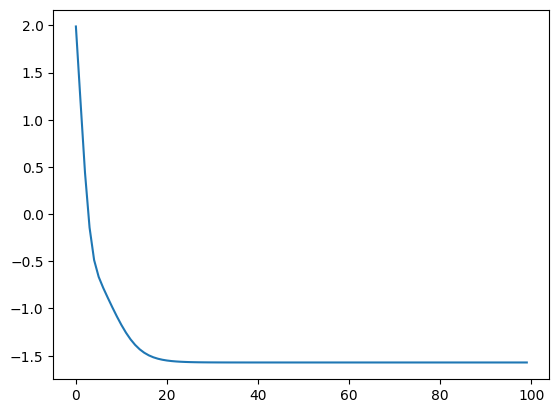

In [21]:
import matplotlib.pyplot as plt

plt.plot(hist)
plt.show()